# Deep Learning (DL)

## What is it?

Machine Learning based on artificial neural networks (NN) which are computing systems inspired by the biological neural networks that constitute animal brains.

### Neural Network

_"The universal approximation theorem of feed-forward neural networks states that every
continuous function on a compact subset $R^n$ can be arbitrary well approximated by a
feed-forward neural network with one hidden layer, a finite number of neurons, and some
mild assumptions about the activation function"_

- What is a neuron?

[<img src="resources/5/neuron.png" width="700"/>](resources/5/neuron.png)


- What is a feed-forward neural network?

[<img src="resources/5/neural_network_3.png" width="500"/>](resources/5/neural_network_3.png)


- How can it fit a function at all?

Simple approximation:

[<img src="resources/5/simple_approx.png" width="600"/>](resources/5/simple_approx.png)

Complex approximation:

[<img src="resources/5/complex_approx.png" width="600"/>](resources/5/complex_approx.png)


### Deep Neural Network

_"The number of linear regions in a feed-forward neural network grows exponentially with depth $L$ and polynomial
with the number of neurons $n$ per hidden layer. Therefore, the number of linear regions grows much faster for deep architectures compared to shallow architectures with $nL$
hidden neurons"_

ResNet, a deep residual neural network:

[<img src="resources/5/ResNet.png" width="800"/>](resources/5/ResNet.png)


## How does it work?

### Prediction by Forward pass

A datapoint travels thorugh the network and creates a prediction.

### Training by Backward pass

A _loss function_ measures the incorrectness of a prediction. Training happends when _backpropagation_ first computes the gradient of the loss function the with respect to the weights and biases of the network for a single input–output example by using the _chain rule_, and secondly updates the weights and biases by using the _delta rule_.

[<img src="resources/5/gradient_decent.jpeg" width="800"/>](resources/5/gradient_decent.jpeg)


## Why is it useful?

Since can arbitrary well approximate any relationship between input and output, it is usefull for complex data structures such as natrual language, images, audio and signals, time-series, or combinations of different data structures.

Applications are

- Natural Language Processing (NLP)
- Image analysis
- Audio and signal processing
- Time-series forcasting
- Reinforcement learning!

From Papers with Code:

[<img src="resources/5/application.png" width="800"/>](resources/5/application.png)

## Demonstration

Predict flowers using a Convolutional Neural Network (CNN).

The architecture is based on four types of layers
- Firstly, a convolutional layer for two-dimentional data (square) followed by a max-pooling layer for two-dimentional data, repeated three times, which learns features. 
- Secondly, a dropout layer to combat overfitting, by dropping features at random. 
- Lastly, two fully connected (dense) layers which predicts the class confidence based on the learned features.


In [1]:
import os
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
print("CPU's:", tf.config.list_physical_devices("CPU"))
print("GPU's:", tf.config.list_physical_devices("GPU"))

CPU's: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU's: []


In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

'''
flower_photo/
  LICENSE.txt
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
'''

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
IMG_DEPTH = 3

Image count: 3670
Class names: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
Length of train dataset: 2936
Length of val dataset: 734
Image shape:  (180, 180, 3)
Label:  0


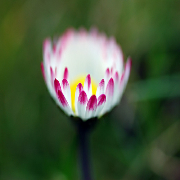

In [47]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Image count:", image_count)

# Loads file names into dataset
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"]))
print("Class names:", class_names)

print("Length of train dataset:", tf.data.experimental.cardinality(train_ds).numpy())
print("Length of val dataset:", tf.data.experimental.cardinality(val_ds).numpy())

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=IMG_DEPTH)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_image(img)
    return img, label

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

PIL.Image.fromarray(image.numpy().astype("uint8"), "RGB")


Note that the preprocessing code gives floats. Visualization must convert it to uint8 (0->255).

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Label: 0


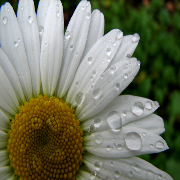

In [48]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

# Display example image
img, label = next(train_ds.take(1).as_numpy_iterator())
img = img[0,:].astype("uint8")
print("Label:", label[0])
PIL.Image.fromarray(img, "RGB")

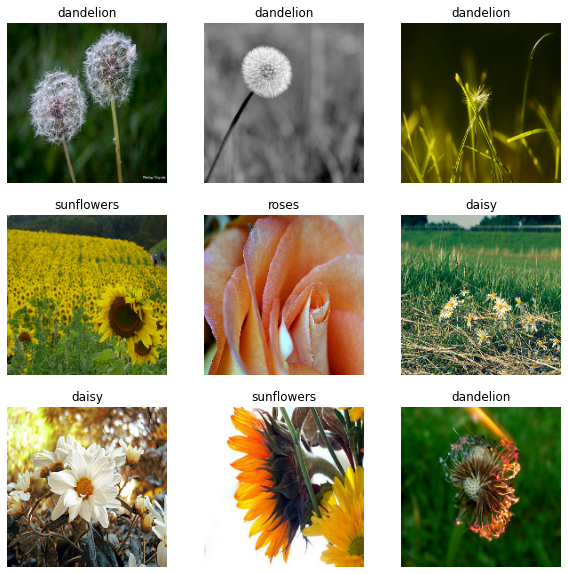

In [49]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis("off")

In [50]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [51]:
train_ds = train_ds.cache().shuffle(1000) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_ds.cache() \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [8]:
# https://medium.com/ydata-ai/how-to-use-tensorflow-callbacks-f54f9bb6db25
# tensorboard --logdir "logs/image_classification"

from datetime import datetime
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

def prepare_callbacks(model_name):
    callbacks = []
    timestamp = int(datetime.now().timestamp())
    # EarlyStopping
    early_stopping_patience = 5
    callbacks.append(EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True))

    # ModelCheckpoint
    checkpoint_dir = "./checkpoints/image_classification/"
    checkpoint_filepath = checkpoint_dir + str(timestamp) + "_" + model_name
    # checkpoint_filepath = checkpoint_dir + 'checkpoint'

    callbacks.append(ModelCheckpoint(
        monitor="val_loss", filepath=checkpoint_filepath, save_best_only=True, mode="min"))

    # Tensorboard
    tensorboard_log_dir = f"./logs/image_classification/{timestamp}"
    callbacks.append(TensorBoard(log_dir=tensorboard_log_dir))

    # ReduceLROnPlateau
    callbacks.append(ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, min_lr=0.0005))

    return callbacks

In [9]:
def create_compile_model(model_name, print_summary=False):
    input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
    model = tf.keras.models.Sequential(
        layers=[
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
            tf.keras.layers.Conv2D(16, 3, padding='same', activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, 3, padding='same', activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")],
        name=model_name)

    metrics = ["accuracy"]  # tf.keras.metrics.CategoricalAccuracy()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=metrics,
    )

    if print_summary:
        print(model.summary())
    
    return model, metrics

In [14]:
EPOCHS = 25

def train_model(epochs=EPOCHS):
    model_name = input()
    callbacks = prepare_callbacks(model_name)
    model, metrics = create_compile_model(model_name, print_summary=True)
    epochs=epochs
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    return history, metrics, model

In [16]:
history, metrics, model = train_model()

e25
Model: "e25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                       

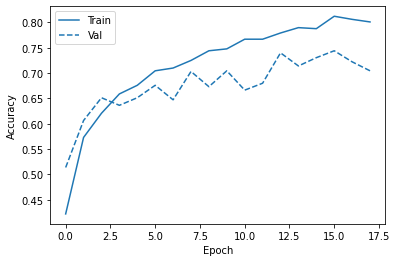

In [17]:
def plot_metrics(history, metrics):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if not isinstance(metrics[0], str):
        metrics = [metric.name for metric in metrics]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot((len(metrics) + 1) // 2,(len(metrics) + 1) // 2, n + 1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()

plot_metrics(history, metrics)

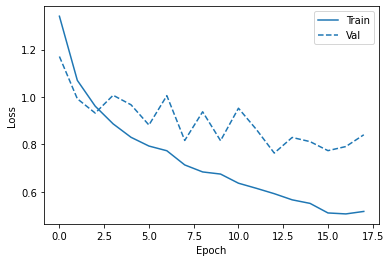

In [18]:
def plot_loss(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.plot(history.epoch,  history.history["loss"], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_loss'], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel("Loss")
    plt.legend()

plot_loss(history)

In [19]:
def get_best_model():
    """Gets best model from checkpoints.
    
    Return (best model, model name, validation loss, categorical accuracy)
    """
    loss_model = {}
    for model_path in pathlib.Path("./checkpoints/image_classification").glob(pattern="*"):
        model_name = model_path.name.split("/")[-1]
        loaded_model = tf.keras.models.load_model(model_path)
        val_loss, categorical_accuracy = loaded_model.evaluate(val_ds)
        loss_model[val_loss] = (loaded_model, model_name, val_loss, categorical_accuracy)
        print("model name:", model_name)
        print("val_loss:", round(val_loss,3))
        print("categorical_accuracy:", round(categorical_accuracy, 3))

    return loss_model[min(loss_model.keys())]

best_model, model_name, val_loss, categorical_accuracy = get_best_model()

print("\n" + "".join(["="]*25))
print("Best model:", model_name)
print("Best val_loss:", round(val_loss,3))
print("Best categorical_accuracy:", round(categorical_accuracy, 3))

23/23 [==============================] - 2s 81ms/step - loss: 0.8868 - accuracy: 0.6580
model name: 1650583037_e5
val_loss: 0.887
categorical_accuracy: 0.658
23/23 [==============================] - 2s 82ms/step - loss: 0.7637 - accuracy: 0.7398
model name: 1650583493_e25
val_loss: 0.764
categorical_accuracy: 0.74

Best model: 1650583493_e25
Best val_loss: 0.764
Best categorical_accuracy: 0.74


In [20]:
import tensorflow.keras.backend as K
print(K.eval(best_model.optimizer.get_config()))
print(best_model.summary())

{'name': 'Adam', 'learning_rate': 0.0005000000237487257, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
Model: "e25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                            

In [55]:
def predict_and_plot(model, dataset):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      pred = model.predict(tf.expand_dims(images[i],0))
      pred_label = CLASS_NAMES[labels[np.argmax(pred)]]
      true_label = CLASS_NAMES[labels[i]]
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
      plt.axis("off")

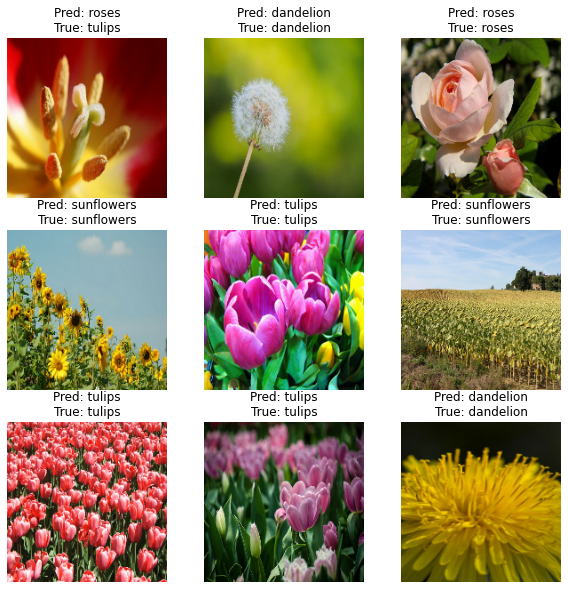

In [57]:
predict_and_plot(best_model, val_ds)

## No free lunch theorem

There are no free lunch, and espesially not within deep learning! Establish a baseline with the simplest possible solution first, then try to beat it.
